In [13]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from DS_data_transformation import get_prm
from DS_Planck_Unet import val_pix
from DS_healpix_fragmentation import radec2pix

In [2]:
dirname = '/home/rt2122/Data/cur/recall2epoch/'
files = next(os.walk(dirname))[-1]
model_files = {}
model_files['pz'] = [s for s in files if s[:len('pz_ep')] == 'pz_ep']
model_files['pz_act'] = [s for s in files if s[:len('pz_act')] == 'pz_act']

In [4]:
tr_cats = {'PSZ2' : pd.read_csv('/home/rt2122/Data/original_catalogs/csv/PSZ2.csv'), 
          'MCXC' : pd.read_csv('/home/rt2122/Data/original_catalogs/csv/MCXC.csv'), 
          #'RM' : pd.read_csv('/home/rt2122/Data/original_catalogs/csv/RM.csv'), 
          'ACT' : pd.read_csv('/home/rt2122/Data/original_catalogs/csv/ACT.csv'),
          'planck_z' : pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv')}

In [14]:
for name in tr_cats:
    df = tr_cats[name]
    tr_cats[name] = df[np.in1d(radec2pix(df['RA'], df['DEC'], 2), val_pix)]

In [7]:
def match2dfs(df, tdf, match_dist=5/60):
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    
    sc = SkyCoord(ra=np.array(df['RA'])*u.degree, dec=np.array(df['DEC'])*u.degree, frame='icrs')
    tsc = SkyCoord(ra=np.array(tdf['RA'])*u.degree, dec=np.array(tdf['DEC'])*u.degree, frame='icrs')
    idx, d2d, _ = sc.match_to_catalog_sky(tsc)
    matched = d2d.degree <= match_dist
    df.loc[matched, 'matched'] = True
    return np.count_nonzero(matched), len(set(idx[matched]))

In [28]:
def extract_recall(df, with_fp=True):
    import numpy as np
    line = {}
    df['matched'] = False
    for cat in tr_cats:
        c, c1 = match2dfs(df, tr_cats[cat])
        line[cat] = c1 / len(tr_cats[cat])
    line['fp'] = len(df) - np.count_nonzero(df['matched'])
    return line

In [29]:
model_dict = {'pz' : [], 'pz_act' : []}
for model in model_dict:
    cur_files = model_files[model]
    for file in cur_files:
        df = pd.read_csv(os.path.join(dirname, file))
        df = df[df['status'] != 'fn']
        df.index = np.arange(len(df))
        line = extract_recall(df)
        model_dict[model].append(pd.DataFrame(line, index=[int(get_prm('ep', file))]))
    model_dict[model] = pd.concat(model_dict[model]).sort_index()

In [30]:
v = {'pz' : 14, 'pz_act' : 10}

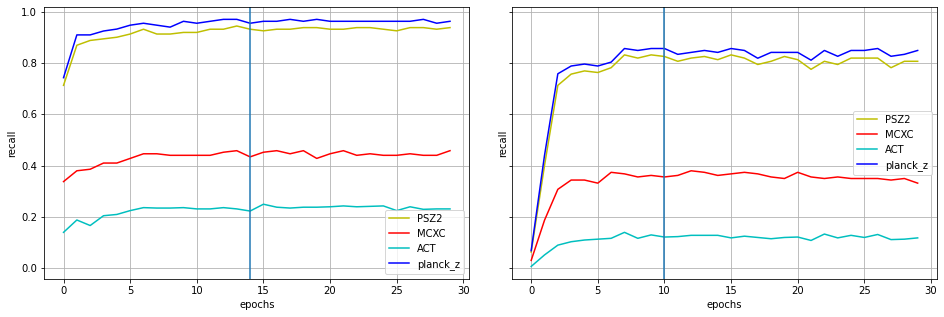

In [35]:
_, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
plt.subplots_adjust(wspace=0.1)
for i, model in enumerate(model_dict):
    for cat, c in zip(tr_cats, 'yrcb'):
        line, = ax[i].plot(np.arange(0, 30), model_dict[model][cat], c=c)
        if cat == 'act':
            cat = 'actwp'
        line.set_label(cat)

    line = ax[i].axvline(v[model])
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel('recall')
    ax[i].grid()
    ax[i].legend()

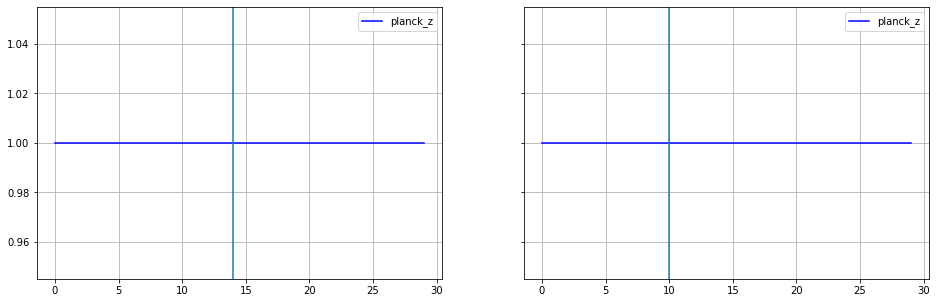

In [23]:
_, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
for i, model in enumerate(model_dict):
    for cat, c in zip(['planck_z'], 'b'):
        line, = ax[i].plot(np.arange(0, 30), model_dict[model][cat], c=c)
        line.set_label(cat)
        if cat == 'act':
            cat = 'actwp'

    line = ax[i].axvline(v[model])
    #ax[i].text(5, 0.75, 'val_pix ' + model)
    ax[i].grid()
    ax[i].legend()

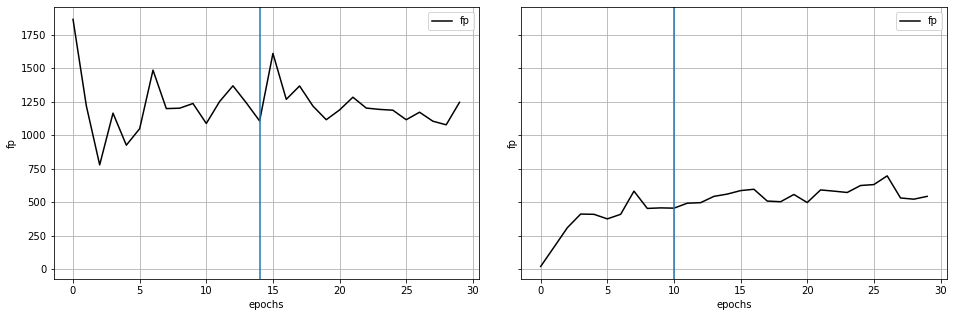

In [37]:
_, ax = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
plt.subplots_adjust(wspace=0.1)
for i, model in enumerate(model_dict):
    for cat, c in zip(['fp'], 'k'):
        line, = ax[i].plot(np.arange(0, 30), model_dict[model][cat], c=c)
        line.set_label(cat)
        if cat == 'act':
            cat = 'actwp'

    line = ax[i].axvline(v[model])
    #ax[i].set_yticks(np.arange(0, 1900, 100))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel('fp')
    ax[i].grid()
    ax[i].legend()